<a href="https://colab.research.google.com/github/Kart8ik/BETA/blob/main/pytorch_101_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# neural network classfication with pytorch

classification is where we predict whether something is one or the other or multiple other things

In [119]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state = 67)

len(X), len(y)

(1000, 1000)

In [120]:
X[:5], y[:5]

(array([[ 0.23322965,  0.81082078],
        [ 0.17566049, -1.00052258],
        [-0.60652456,  0.54412247],
        [ 0.45322431, -0.67309907],
        [ 0.13349703,  0.8368765 ]]),
 array([1, 0, 1, 1, 1]))

In [121]:
import pandas as pd
circles = pd.DataFrame({"X1" : X[:, 0],
                        "X2" : X[:, 1],
                        "label" : y})
circles.head(10)

,X1,X2,label
0,0.233230,0.810821,1
1,0.175660,-1.000523,0
2,-0.606525,0.544122,1
3,0.453224,-0.673099,1
4,0.133497,0.836877,1
5,0.945286,0.246178,0
6,-0.604304,-0.740591,0
7,0.265647,-0.994599,0
8,0.198110,0.801100,1
9,0.261467,-0.743377,1


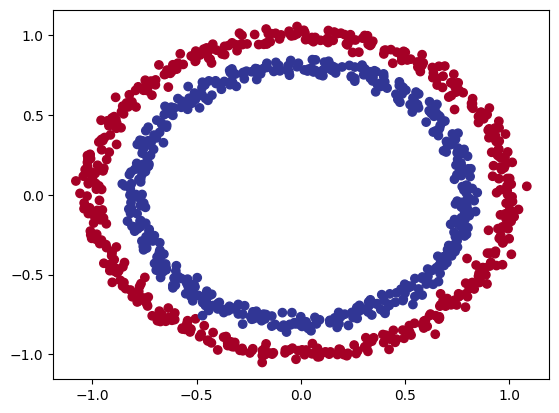

In [122]:
import matplotlib.pyplot as plt

plt.scatter( x= X[:, 0], y= X[:, 1], c= y, cmap= plt.cm.RdYlBu)

In [123]:
X.shape, y.shape

((1000, 2), (1000,))

In [124]:
import torch

torch.__version__

'2.6.0+cu124'

In [125]:
X_TENSOR = torch.from_numpy(X).type(torch.float)
Y_TENSOR = torch.from_numpy(y).type(torch.float)

X_TENSOR.dtype, Y_TENSOR.dtype
X_TENSOR.requires_grad

False

In [126]:
from sklearn.model_selection import train_test_split

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_TENSOR, Y_TENSOR, test_size= 0.2, random_state= 67)

In [127]:
len(X_TRAIN), len(X_TEST),len(Y_TRAIN), len(Y_TEST)

(800, 200, 800, 200)

# building the model

lets build the model to classify our blue and red torch.DoubleTensor

1. setup device agnostic code so ur code runs on plt.ginput
2. construct a model subclassing `nn.Module`
3. define loss function and optimizer
4. create training and testing loop

In [128]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##improving the model

1. add more layers
2. add more hidden units
3. fit for longer
4. changing the activation function
5. changing the learning rate
6. changing the loss function

In [129]:
class CircleClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    # create 2 linear layers capable of handling shape of data
    # self.layer_1 = nn.Linear(in_features=2, out_features=5) #takes 2 features and upscales it into 5 features
    # self.layer_2 = nn.Linear(in_features=5, out_features=1) #takes 5 features and returns a single output
    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=2, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1)
    )

  def forward(self, x):
    # return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output
    return self.two_linear_layers(x)

model_0 = CircleClassifier().to(device)
model_0

CircleClassifier(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [130]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [131]:
# model_0.state_dict()

In [132]:
with torch.inference_mode():
  un_trained_preds = model_0(X_TEST.to(device))
un_trained_preds[:10], Y_TEST[:10]

(tensor([[0.2468],
         [0.2382],
         [0.2410],
         [0.2440],
         [0.2404],
         [0.2453],
         [0.2433],
         [0.2424],
         [0.2452],
         [0.2412]], device='cuda:0'),
 tensor([1., 1., 1., 0., 0., 0., 0., 0., 1., 0.]))

# setting up loss function or optimizer

for classification we usually use binary cross entropy or categorical cross entropy

for optimizers we usually just use SGD or adam

In [133]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.1)

In [14]:
def accuracy_fn( y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

#creating the training and testing loop

1. forward pass
2. calculate loss
3. optimizer zero grad
4. backward prop
5. optimizer step (gradient descent)

In [135]:
torch.manual_seed(67)
torch.cuda.manual_seed(67)

epochs = 1000


X_TRAIN, Y_TRAIN = X_TRAIN.to(device), Y_TRAIN.to(device)
X_TEST, Y_TEST = X_TEST.to(device), Y_TEST.to(device)

for epoch in range(epochs):
  model_0.train()

  Y_LOGIT_TRAIN = model_0(X_TRAIN).squeeze()
  Y_PRED_TRAIN = torch.round(torch.sigmoid(Y_LOGIT_TRAIN))

  loss_train = loss_fn(Y_LOGIT_TRAIN, Y_TRAIN)
  acc_train = accuracy_fn(y_true=Y_TRAIN, y_pred= Y_PRED_TRAIN)

  optimizer.zero_grad()

  loss_train.backward()

  optimizer.step()

  model_0.eval()
  with torch.inference_mode():
    Y_LOGIT_TEST = model_0(X_TEST).squeeze()
    Y_PRED_TEST = torch.round(torch.sigmoid(Y_LOGIT_TEST))

    loss_test = loss_fn(Y_LOGIT_TEST, Y_TEST)
    acc_test = accuracy_fn(y_true= Y_TEST, y_pred= Y_PRED_TEST)

    if epoch % 10 == 0 :
      print(f"epoch : {epoch} | train_loss : {loss_train:.5f}, train_accuracy : {acc_train:.2f}% | test_loss : {loss_test:.5f}, test_accuracy : {acc_test:.2f}%")



epoch : 0 | train_loss : 0.70047, train_accuracy : 49.50% | test_loss : 0.69401, test_accuracy : 52.00%
epoch : 10 | train_loss : 0.69619, train_accuracy : 49.50% | test_loss : 0.69179, test_accuracy : 52.00%
epoch : 20 | train_loss : 0.69399, train_accuracy : 49.50% | test_loss : 0.69095, test_accuracy : 52.00%
epoch : 30 | train_loss : 0.69278, train_accuracy : 49.50% | test_loss : 0.69070, test_accuracy : 52.00%
epoch : 40 | train_loss : 0.69208, train_accuracy : 49.50% | test_loss : 0.69069, test_accuracy : 52.00%
epoch : 50 | train_loss : 0.69165, train_accuracy : 49.50% | test_loss : 0.69078, test_accuracy : 52.00%
epoch : 60 | train_loss : 0.69136, train_accuracy : 51.00% | test_loss : 0.69087, test_accuracy : 54.00%
epoch : 70 | train_loss : 0.69113, train_accuracy : 64.88% | test_loss : 0.69094, test_accuracy : 64.00%
epoch : 80 | train_loss : 0.69095, train_accuracy : 71.62% | test_loss : 0.69097, test_accuracy : 74.00%
epoch : 90 | train_loss : 0.69079, train_accuracy : 70.2

##make predictions and evaluate the model

we need to see why it aint learning bruv

In [136]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



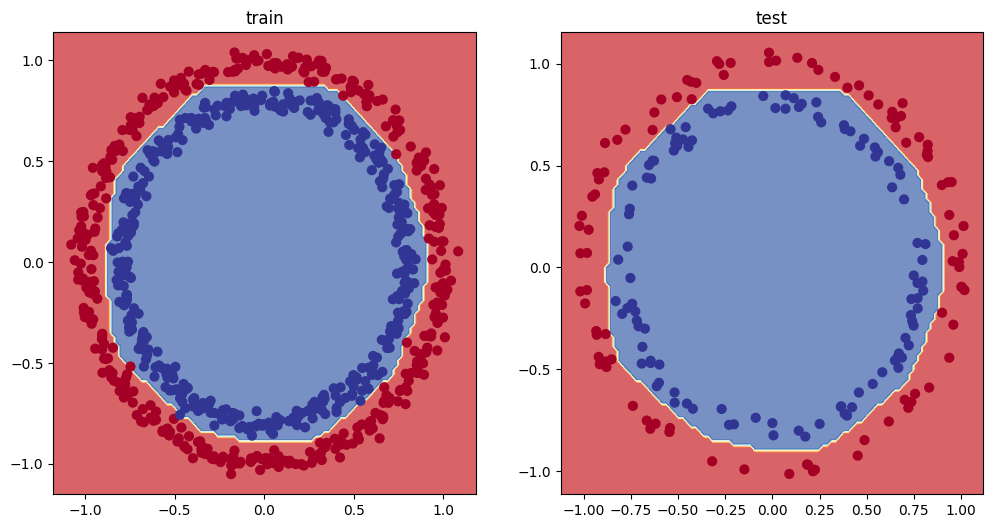

In [137]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_0, X_TRAIN, Y_TRAIN)
plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(model_0, X_TEST, Y_TEST)

#MULTI CLASS CLASSIFICATION

#creating a toy dataset

In [4]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 67

X_blobs, y_blobs = make_blobs(n_samples = 1000,
                              n_features= NUM_FEATURES,
                              centers= NUM_CLASSES,
                              cluster_std=1.5,
                              random_state=RANDOM_SEED)

X_blobs = torch.from_numpy(X_blobs).type(torch.float)
y_blobs = torch.from_numpy(y_blobs).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blobs, y_blobs, test_size= 0.2, random_state=RANDOM_SEED )

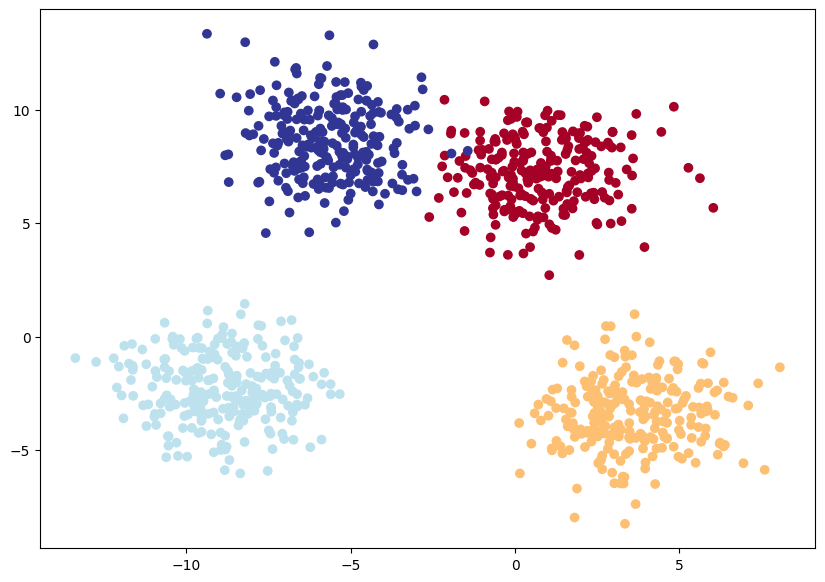

In [5]:
plt.figure(figsize=(10,7))
plt.scatter(X_blobs[:,0],X_blobs[:,1], c=y_blobs, cmap=plt.cm.RdYlBu)

#building the model

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [7]:
class Blob_Classifier(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    """
    Initializes multi-class classficiation model
    Args:
      input_features (int): number of input features to the model
      output_features (int): number of output classes of the model
      hidden_units (int):number of hidden units between layers, default is 8

    Returns: Model

    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


In [8]:
torch.manual_seed(RANDOM_SEED)
model_blob = Blob_Classifier(2,4,16)
model_blob.to(device)

Blob_Classifier(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=4, bias=True)
  )
)

#creating the loss and optimizer functions

In [9]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params = model_blob.parameters(), lr=0.1)

#getting predictions from our multi class model

In [10]:
model_blob.eval()
with torch.inference_mode():
  y_blob_logits = model_blob(X_blob_test.to(device))
y_blob_logits[:10],y_blob_test[:10]

(tensor([[-0.0926,  1.0334,  0.3519, -1.0795],
         [ 0.2664,  0.5312,  0.4958, -1.2961],
         [-0.0278,  1.2047,  0.4670, -1.3819],
         [-0.6095,  0.1515, -0.4015,  0.8457],
         [ 0.2643,  0.7351,  0.5633, -1.4967],
         [ 0.2604,  0.7180,  0.5541, -1.4718],
         [-0.3993, -0.0684, -0.2920,  0.6444],
         [ 0.0089,  1.4928,  0.5973, -1.7453],
         [-0.5244,  0.2791, -0.2835,  0.5464],
         [ 0.3053,  0.9395,  0.6689, -1.7847]]),
 tensor([0, 3, 0, 1, 3, 3, 1, 0, 1, 3]))

In [11]:
y_blob_preds = torch.argmax(torch.softmax(y_blob_logits, dim = 1), dim = 1)
y_blob_preds

tensor([1, 1, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 0, 3, 3, 0, 1, 0, 1, 1, 1, 1, 1, 3,
        3, 0, 0, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 3, 2, 1, 1, 3, 3, 0, 3, 1, 0, 3,
        1, 1, 2, 1, 2, 3, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 2, 3, 1, 1, 2, 3, 1, 1,
        1, 3, 2, 0, 3, 1, 3, 3, 1, 1, 1, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3,
        0, 3, 1, 3, 0, 1, 2, 0, 3, 1, 0, 0, 0, 1, 0, 3, 3, 0, 3, 3, 1, 1, 1, 2,
        1, 1, 1, 2, 3, 1, 0, 2, 1, 1, 0, 3, 0, 1, 3, 3, 1, 3, 1, 0, 1, 1, 3, 1,
        1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 3, 0, 3, 0, 3, 1, 1, 3,
        1, 3, 1, 0, 3, 3, 3, 1, 0, 1, 1, 3, 1, 0, 3, 1, 1, 0, 1, 1, 0, 1, 0, 0,
        1, 3, 1, 1, 1, 1, 1, 1])

#creating the training and testing loop

In [12]:
y_blob_train.dtype

torch.int64

In [15]:
torch.manual_seed(67)
epochs = 1000

X_blob_train, X_blob_test = X_blob_train.to(device), X_blob_test.to(device)
y_blob_train, y_blob_test = y_blob_train.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_blob.train()

  y_blob_train_logits = model_blob(X_blob_train)

  y_blob_train_preds = torch.argmax(torch.softmax(y_blob_train_logits, dim=1), dim=1)

  loss_blob_train = loss_fn(y_blob_train_logits, y_blob_train)

  acc_blob_train = accuracy_fn(y_blob_train, y_blob_train_preds)

  optimizer.zero_grad()

  loss_blob_train.backward()

  optimizer.step()

  model_blob.eval()
  with torch.inference_mode():
    y_blob_test_logits = model_blob(X_blob_test)
    y_blob_test_preds = torch.argmax(torch.softmax(y_blob_test_logits, dim=1), dim=1)

    loss_blob_test = loss_fn(y_blob_test_logits, y_blob_test)

    acc_blob_test = accuracy_fn(y_blob_test, y_blob_test_preds)

    if epoch % 50 == 0:
      print(f"epoch : {epoch} | train_loss : {loss_blob_train:.5f},  train_acc : {acc_blob_train:.2f}% | test_loss : {loss_blob_test:.5f}, test_acc : {acc_blob_test:.2f}")



epoch : 0 | train_loss : 2.02787,  train_acc : 0.88% | test_loss : 0.41353, test_acc : 77.00
epoch : 50 | train_loss : 0.03896,  train_acc : 99.12% | test_loss : 0.03651, test_acc : 99.00
epoch : 100 | train_loss : 0.02874,  train_acc : 99.38% | test_loss : 0.02541, test_acc : 99.00
epoch : 150 | train_loss : 0.02540,  train_acc : 99.38% | test_loss : 0.02175, test_acc : 99.00
epoch : 200 | train_loss : 0.02378,  train_acc : 99.38% | test_loss : 0.01990, test_acc : 99.00
epoch : 250 | train_loss : 0.02280,  train_acc : 99.38% | test_loss : 0.01873, test_acc : 99.00
epoch : 300 | train_loss : 0.02213,  train_acc : 99.38% | test_loss : 0.01787, test_acc : 99.00
epoch : 350 | train_loss : 0.02162,  train_acc : 99.38% | test_loss : 0.01720, test_acc : 99.00
epoch : 400 | train_loss : 0.02121,  train_acc : 99.38% | test_loss : 0.01662, test_acc : 99.00
epoch : 450 | train_loss : 0.02087,  train_acc : 99.38% | test_loss : 0.01612, test_acc : 99.00
epoch : 500 | train_loss : 0.02056,  train_a

In [16]:
import numpy as np

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())



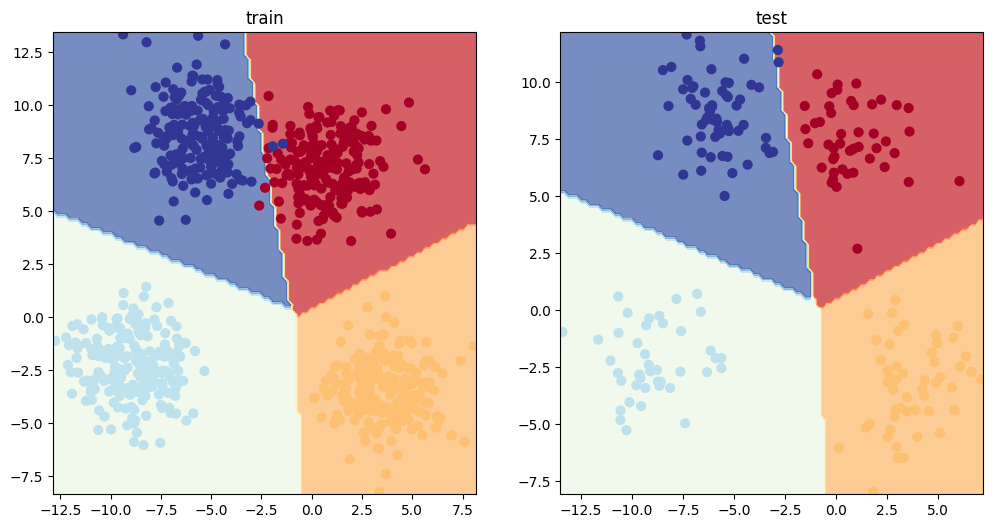

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('train')
plot_decision_boundary(model_blob, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title('test')
plot_decision_boundary(model_blob, X_blob_test, y_blob_test)

#A Few more classification metrics

* Accuracy - how many samples it gets right out of 100 samples
* Precision
* ReCall
* F1-score
* Confusion Matrix
* Classification report

In [18]:
# !pip install torchmetrics

In [19]:
import torchmetrics

In [27]:
from torchmetrics import Accuracy
acc = Accuracy(task='multiclass', num_classes=4)
acc(y_blob_test_preds, y_blob_test)

tensor(0.9900)